# Creation of spectrum
Authors: Antoine BOURGEOIS, Stella HADIWIDJAJA, Zoltan NICOT-SENNEVILLE

In [40]:
%run functions_opensource.py

Name the cell (which will be used to label all files generated).


In [41]:
name_of_cell = 'test cell'

# Part 1: Base Spectrum Fitting

In order to obtain a calibrated spectrum, we first need to create a spectrum that approximates the reference spectrum, which we refer to as the base spectrum. This is a general spectrum fitting with no calibration in mind.

Please enter the filepath of your Reference spectrum, as well as the Reference cells used for calibration.

- Your reference spectrum files should have the first line with **two columns** named:  
  `Wavelength (nm)`, `Irradiance (W/m²/nm)`  

In [42]:
# Set path to Solar Simulator LEDs
Solar_Simulator_LEDs_path = 'Data/Solar Simulator LEDs/Solar Simulator 1'

# Load reference spectrum Eref
E_ref = pd.read_csv(r"Data/Reference Spectrum/IEC_AM15G.csv", delimiter=',')
beginning_w = 350
end_w=1120

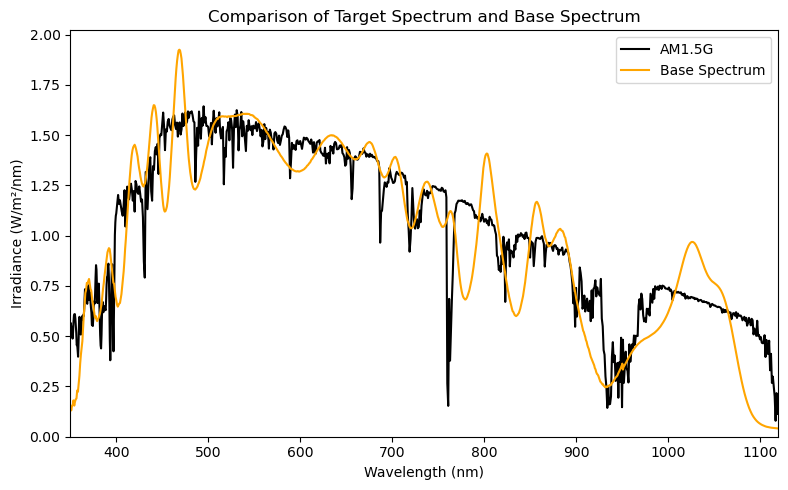

In [43]:
# If you have an initial guess, insert as a list. Otherwise, leave initial_guess=None
# initial_guess = [0.283738,0.308447,0.431836,0.203661,0.290945,0.255199,0.463444,0.384196,0.978895,0.158744,0.980832,0.184615,0.179251,0.739054,0.324144,0.490861,0.967272,0.680343,0.603946,0.191524,0.576209]
# If you already have your own spectum fitting routine, you can skip this step and directly input the control parameters for the base spectrum as base_alphas, and the spectrum as base_spectrum.
base_spectrum,base_spectrum_alphas = fit_spectrum(E_ref, Solar_Simulator_LEDs_path=Solar_Simulator_LEDs_path, recipe_name=name_of_cell,  beginning_w=beginning_w, end_w=end_w, show_plot=True,initial_guess=None)

# Part 2: Initialisation of Calibration

Please enter the name of the Device Under Test (DUT), and specify which Solar Simulator you're using (1 or 2).

Please enter the file paths for the EQE data of the top and bottom junctions.

**Note:**  
- The EQE files must be in `.csv` format.  
- The first row of each file should contain the following columns in this exact order:  
  `Wavelength (nm)`, `SR (A/W)`
- Your reference cells files should have the first line with **columns** named:  
  `Wavelength (nm)`, `SR (A/W)`
       

In [44]:
# Plot EQE
PVSK = pd.read_csv(r'Data/EQE/Example Tandem Cell/Example Cell top.csv')
Si = pd.read_csv(r'Data/EQE/Example Tandem Cell/Example Cell bot.csv')

# Load reference cells:
KG3 = import_data(r"Data/EQE/Reference Cells/WPVS-BL7.csv")
BL7 = import_data(r"Data/EQE/Reference Cells/WPVS-KG3.csv")

# Define the sub-cells and reference cells as dictionaries
DUTs = {
    'TOP': PVSK,
    'BOT': Si}

RCs = {
    'KG3': KG3,
    'BL7': BL7
}


## Part 3: Calibration

In [45]:
#Enter the path of your "approximated spectrum" recipe that you just created
#base_spectrum_alphas = read_wspc_recipe('./Data/Spectra Recipes/'+f'{name_of_cell}.wspc')
LEDs = get_LEDs(beginning_w,end_w,Solar_Simulator_LEDs_path)
base_spectrum = inter_array(base_spectrum_alphas*100,LEDs)

In [46]:
# Perform calibration
result = calibrate_based_on_best_splitting(DUTs, RCs, E_ref, base_spectrum_alphas*100,name_of_cell, Solar_Simulator_LEDs_path, beginning_w=beginning_w, end_w=end_w)

# save full results as a pickle
with open(name_of_cell+"-full_results_calibrated.pkl", "wb") as f:
    pickle.dump(result,f)

Mismatch factors before calibration: Mtop = 1.061, Mbot = 0.949
Best calibration with 15 LEDs in source 1, Mtop = 1.007, Mbot = 1.002


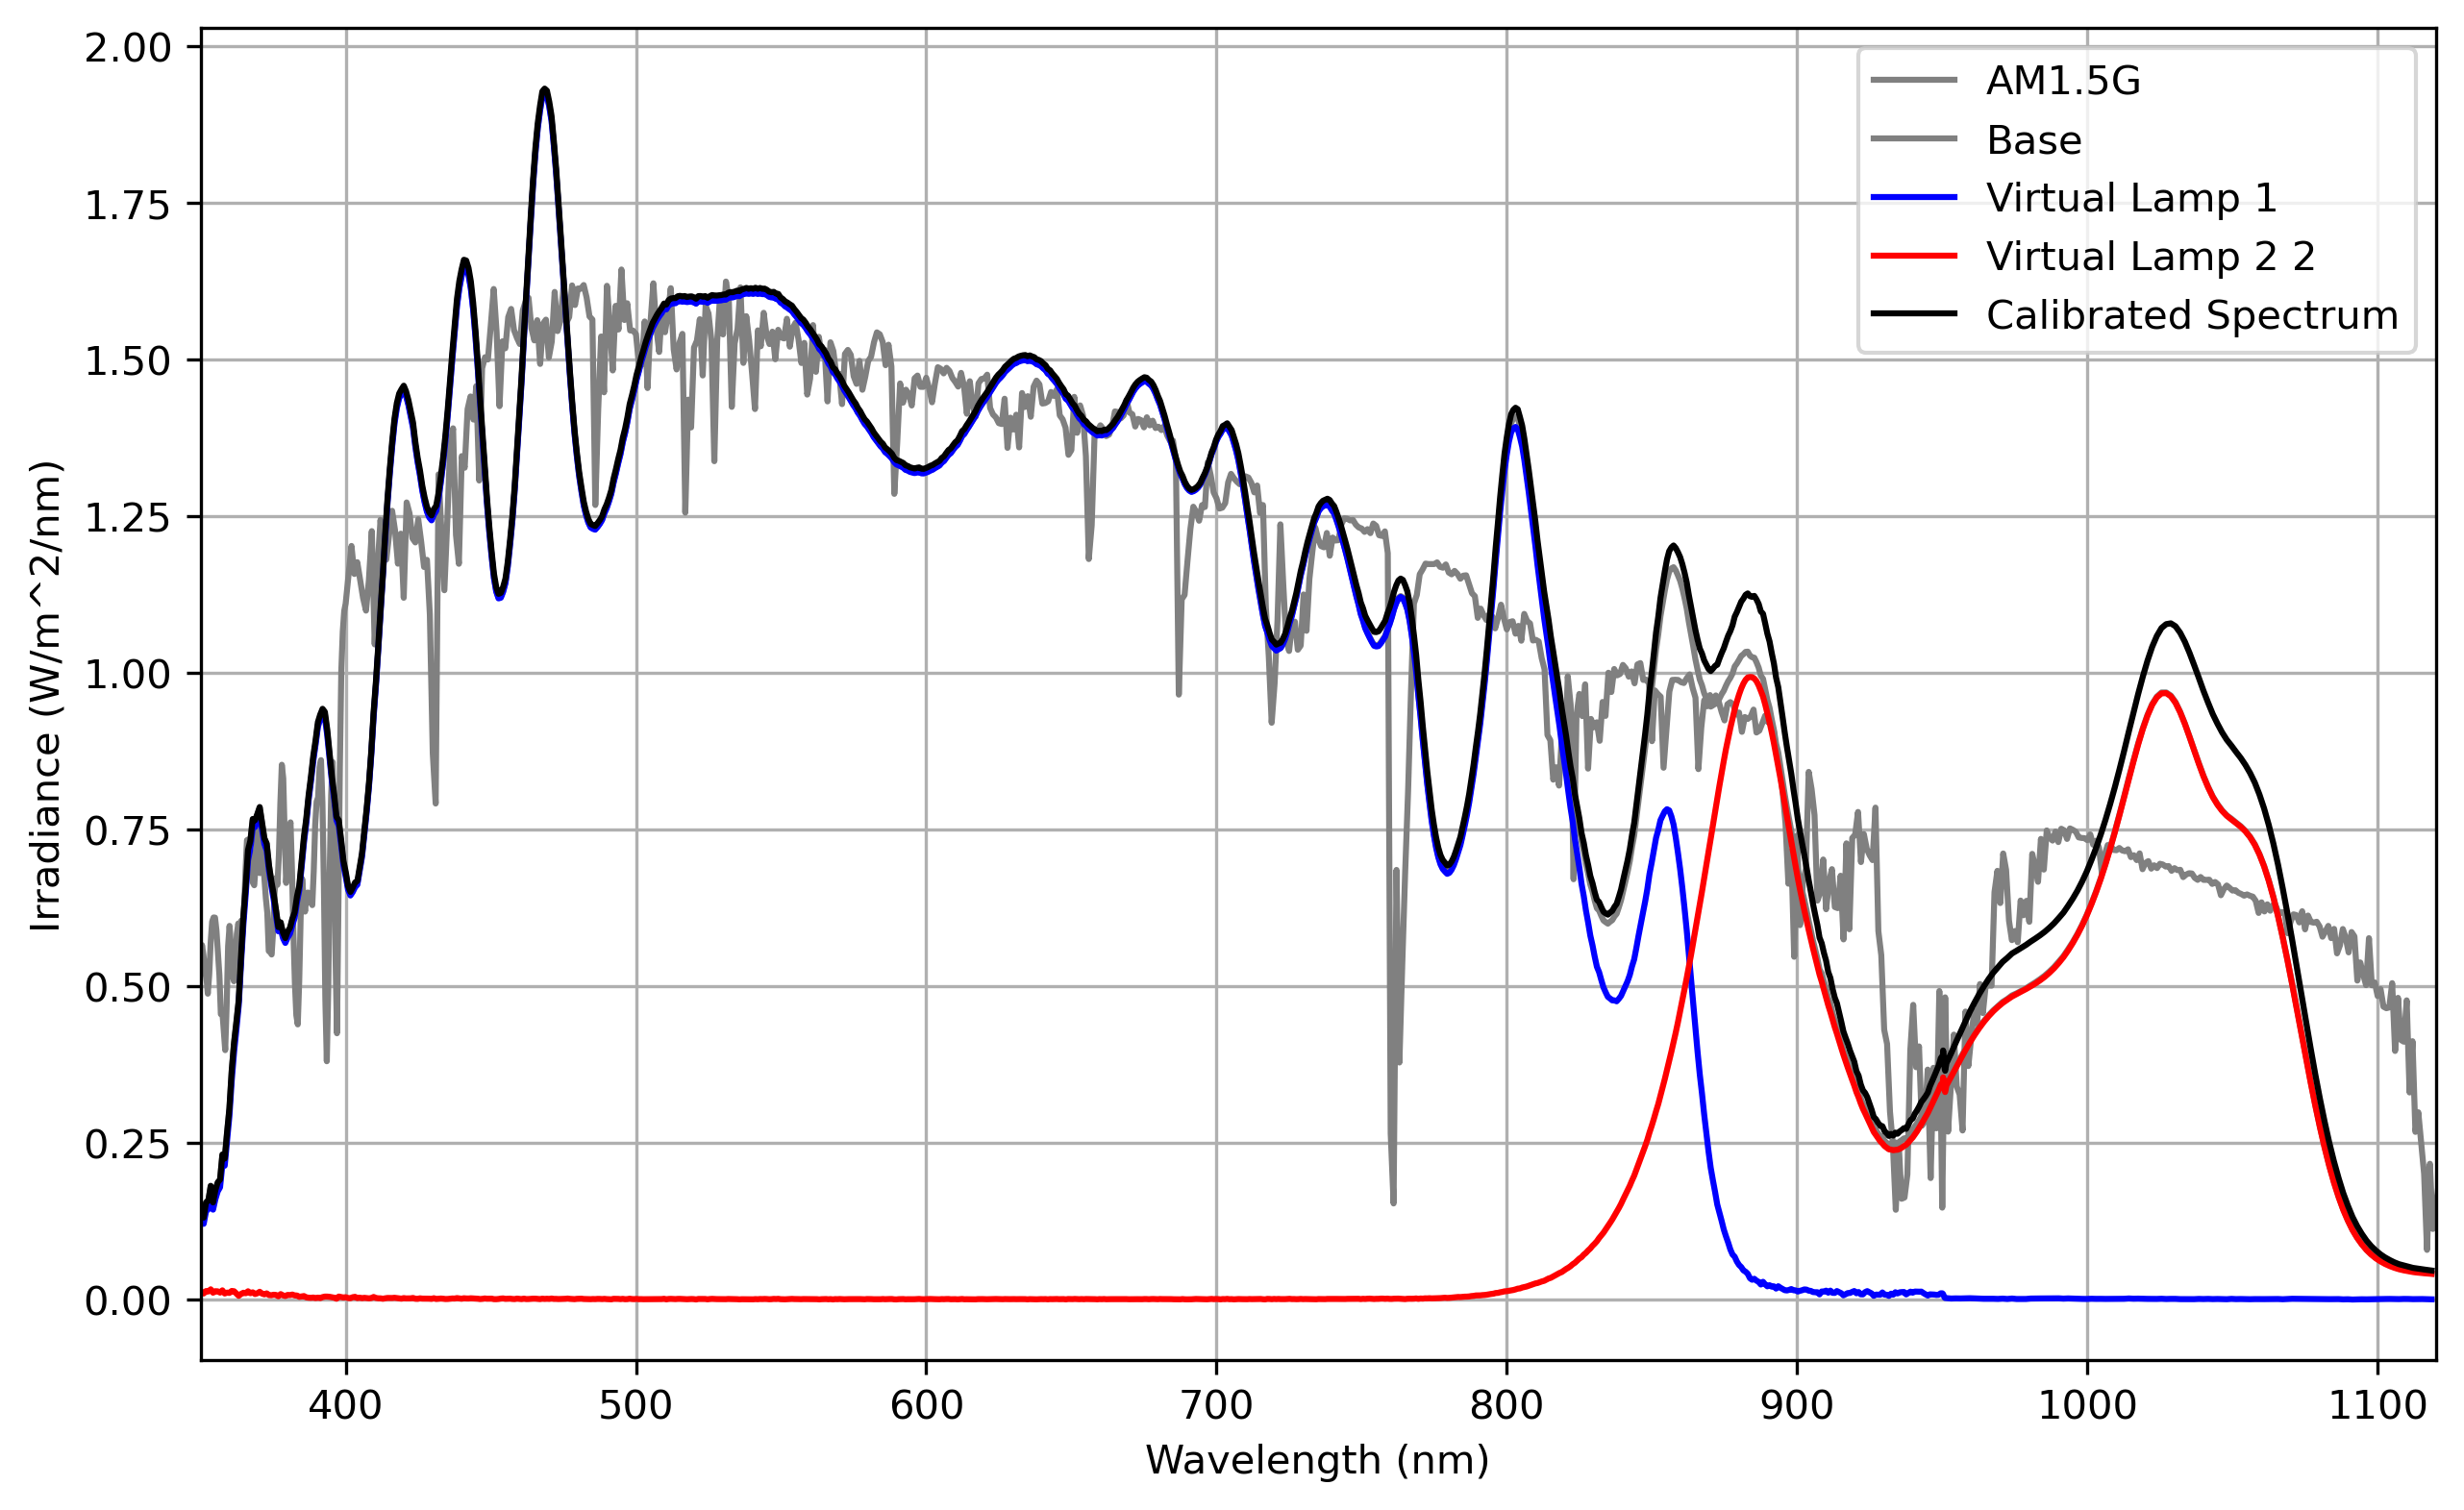

In [49]:
# Compare calibrated spectrum to AM1.5G
theoretical_cal_spectrum = result['calibrated_spectrum']
split_lamp_cal_spectrum_1 = result['split_calibrated_spectrum'][0]
split_lamp_cal_spectrum_2 = result['split_calibrated_spectrum'][1]

fig, ax1 = plt.subplots(figsize=(10, 6),dpi =300)

# Primary y-axis
ax1.plot(E_ref['Wavelength (nm)'], E_ref['Irradiance (W/m^2/nm)'], label='AM1.5G', color='grey')
ax1.plot(base_spectrum['Wavelength (nm)'], base_spectrum['Irradiance (W/m^2/nm)'], label='Base', color='grey')
ax1.plot(split_lamp_cal_spectrum_1['Wavelength (nm)'], split_lamp_cal_spectrum_1['Irradiance (W/m^2/nm)'], label='Virtual Lamp 1', color='blue')
ax1.plot(split_lamp_cal_spectrum_2['Wavelength (nm)'], split_lamp_cal_spectrum_2['Irradiance (W/m^2/nm)'], label='Virtual Lamp 2 2', color='red')
ax1.plot(theoretical_cal_spectrum['Wavelength (nm)'], theoretical_cal_spectrum['Irradiance (W/m^2/nm)'], label='Calibrated Spectrum', color='black')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Irradiance (W/m^2/nm)')
ax1.set_xlim([beginning_w, end_w])
#ax1.legend(loc='upper left')
ax1.grid(True)
ax1.legend()
plt.show()

Next, measure the calibrated spectrum with a spectrometer. Use the reference cells to measure the irradiance, and calculate the Z-factor